Note: If you are reading in an image using mpimg.imread() this will read in an RGB image and you should convert to grayscale using cv2.COLOR_RGB2GRAY, but if you are using cv2.imread() or the glob API, as happens in this video example, this will read in a BGR image and you should convert to grayscale using cv2.COLOR_BGR2GRAY.

In [3]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


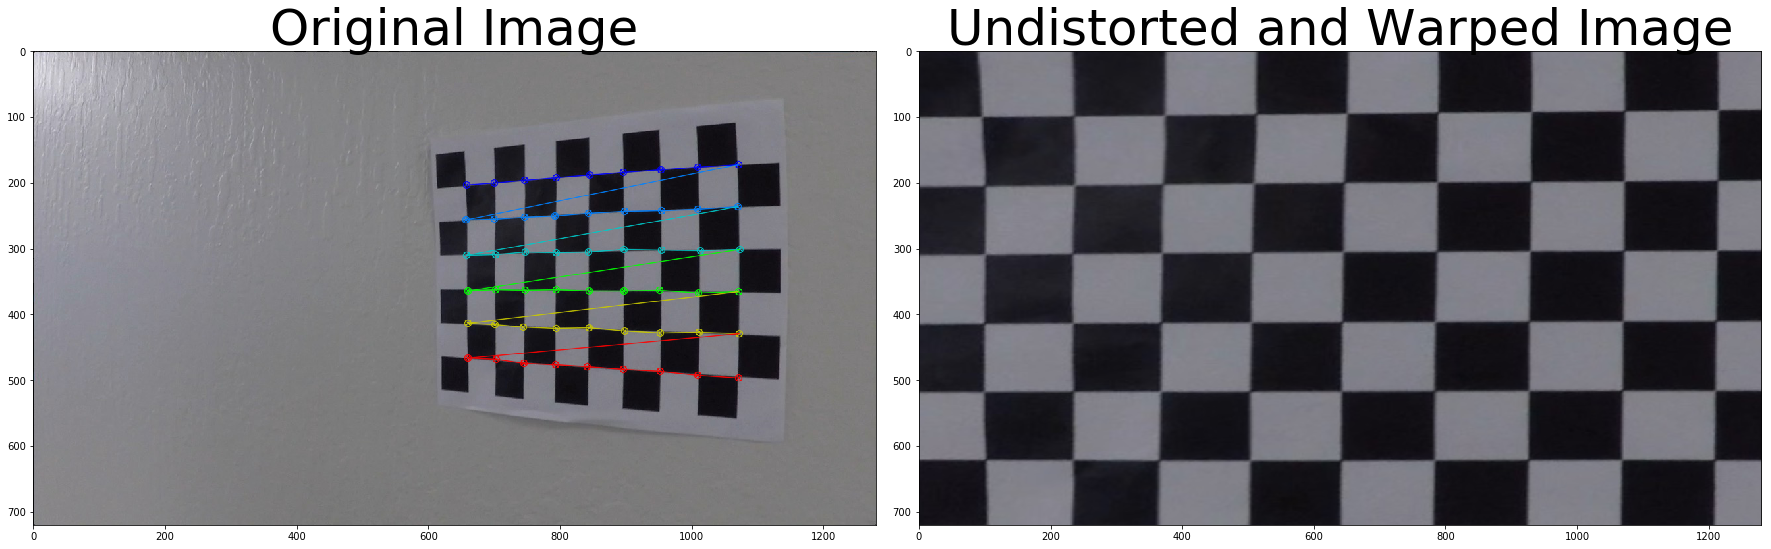

In [4]:
objpoints = []
imgpoints = []


# # Read in the saved camera matrix and distortion coefficients
# # These are the arrays you calculated using cv2.calibrateCamera()
# dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
# mtx = dist_pickle["mtx"]
# dist = dist_pickle["dist"]

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

# over here an image in x,y,z dimensions is getting generated
objp = np.zeros((nx*ny,3), np.float32) # here we leave the z coordinate as it remains 0 by default and we don't need z axis
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # here we get the coordinates of the grid size and we tarnspose it

fnames = glob.glob("camera_cal/calibration*.jpg")

for fname in fnames:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # converting to grayscale
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) # feeding gray image to find corners
    if ret:
        objpoints.append(objp) # object points are detected and appended here, we will use them to calibrate camera
        imgpoints.append(corners)

# use the object and image points to caliberate the camera and compute the camera matrix and distortion coefficients
ret, cameraMatrix, distortionCoeffs, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    # 4) If corners found: 
    if ret == True:
        # print('Corners found, find the image below:')
        # a) draw corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        # print(corners)
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
        offset = 100
        dst= [[offset,offset],[img_size[0]-offset,offset],[img_size[0]-offset, img_size[1]-offset],[offset, img_size[1]-offset]]
        dst = np.float32(dst)
        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src,dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, cameraMatrix, distortionCoeffs)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


1. Perform masking and thresholding techniques to get detect lane lines
2. Perform a perspective transform to get a bird's eye view and get a polynomial
3. Extract the Curvature of the lane from the polynomial we get from step 2



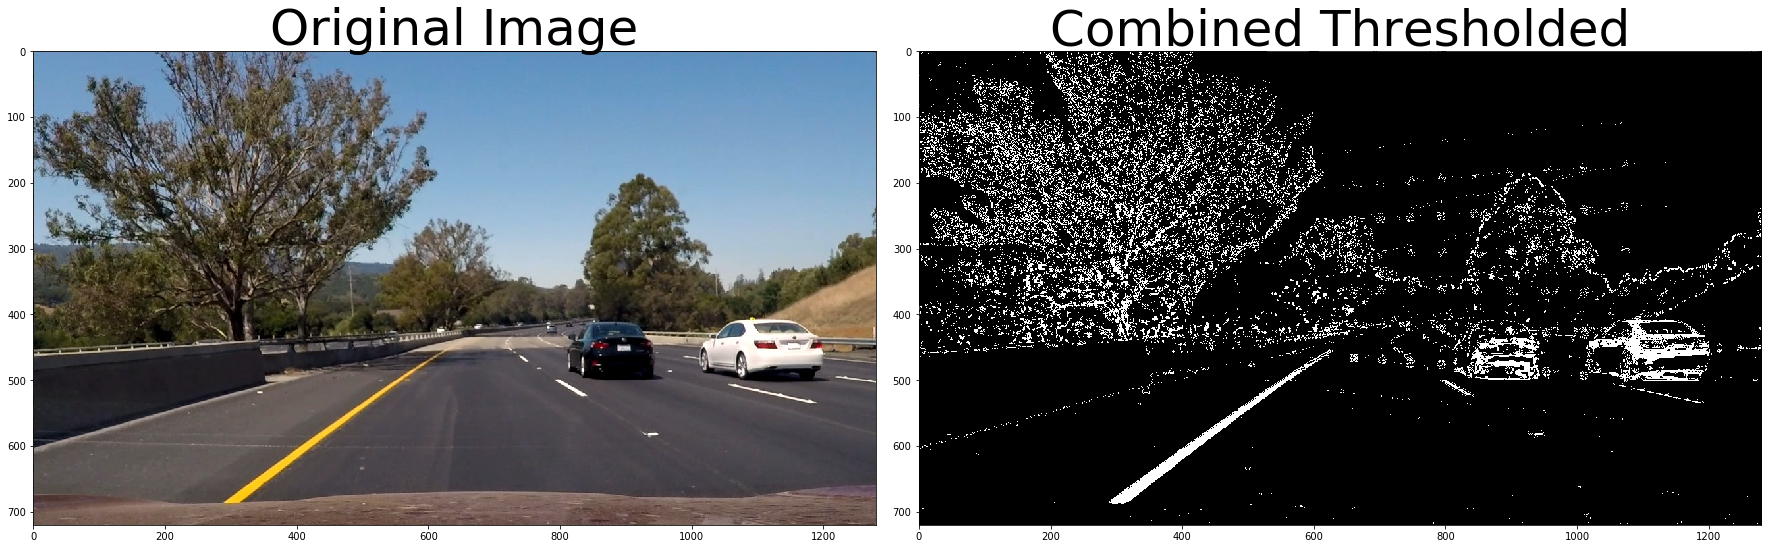

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    grad_binary = binary_output
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    grad_mag = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(grad_mag)/255 
    grad_mag = (grad_mag/scale_factor).astype(np.uint8) 
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(grad_mag)
    binary_output[(grad_mag >= mag_thresh[0]) & (grad_mag <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    mag_binary = binary_output
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    dir_binary =  binary_output
    return dir_binary

def combined_thresholds(img,show=False):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20,100))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7,1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    my_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel =my_image[:,:,2]
    
    # Threshold color channel
    s_thresh_min = 150
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary == 1) | (combined == 1)] = 1
    
    return combined_binary
    
    
image = mpimg.imread('test_images/test6.jpg')
combined = combined_thresholds(image)
# Run the function
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholded', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

Time to do perspective transform

In [6]:
#Transform
def transform_image(img, nx, ny): 
    '''
    In this function, our input should be the image coming from the combined_threshold function'''
    offset = 100 # offset for dst points
    
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    leftupperpoint  = [568,470]
    rightupperpoint = [717,470]
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)
    
    return warped, M

In [11]:
def find_lane_pixels(binary_warped):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
        # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

# Create histogram of image binary activations
binary_warped = combined_thresholds(image)
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


# out_img = fit_polynomial(binary_warped)

# plt.imshow(out_img)
leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)


In [16]:
for i in leftx:
    print(i, end=" ")


1 1 1 1 5 6 1 3 1 1 102 100 95 102 93 99 100 101 88 89 94 81 83 84 89 80 87 88 77 82 43 44 45 46 47 72 73 78 79 44 76 65 72 59 68 69 1 54 55 56 63 73 1 48 49 55 56 57 1 51 1 45 35 36 40 41 30 31 34 40 24 34 35 23 38 17 26 16 17 18 19 8 9 1 5 11 12 1 2 8 25 4 5 2 1 16 17 87 90 1 86 87 90 91 1 1 1 1 1 1 1 0 43 45 47 48 79 80 103 104 114 115 121 122 129 132 138 139 140 141 142 143 147 24 43 44 46 60 78 79 103 104 115 133 139 140 141 0 1 44 45 46 57 58 60 61 64 73 74 75 76 78 79 85 89 106 108 115 122 132 133 139 140 141 142 143 145 146 0 4 45 46 56 74 75 76 78 91 115 123 124 139 140 141 142 143 145 146 0 43 61 75 76 91 92 110 111 112 113 114 142 0 1 3 4 53 55 62 88 91 92 107 108 109 110 111 112 113 114 124 138 142 0 33 40 57 61 90 91 110 111 33 40 91 92 129 35 57 58 92 34 35 86 105 145 11 12 34 35 56 57 120 140 145 1 12 57 80 97 138 145 11 12 37 41 94 11 12 35 36 37 52 53 60 145 8 35 36 52 53 55 61 90 133 134 135 146 3 71 85 86 89 146 13 16 35 36 42 49 52 85 89 90 117 126 129 132 133 135 1

170 171 176 182 195 196 199 207 208 209 210 212 213 17 18 19 21 24 25 26 27 34 36 37 43 44 45 48 85 86 88 89 91 94 95 100 101 117 118 121 135 136 137 154 163 164 165 167 168 170 171 173 174 177 179 188 191 193 194 195 199 209 213 18 19 23 25 26 27 28 36 39 40 43 44 45 47 48 88 89 93 94 97 99 101 102 103 118 119 124 126 136 138 143 145 157 161 163 164 167 168 169 175 176 177 180 181 192 194 195 207 211 212 18 19 20 23 24 27 28 29 34 40 44 48 50 54 57 88 89 99 102 103 104 117 118 121 122 125 126 155 157 158 160 169 170 172 175 179 180 181 190 193 196 197 198 208 209 210 213 19 21 22 23 26 28 31 32 52 53 54 56 59 87 88 93 94 100 101 104 105 118 119 120 121 123 125 126 141 145 147 149 157 161 163 164 166 168 169 173 175 176 177 178 181 183 186 193 213 214 19 20 23 24 26 27 30 31 32 48 54 55 56 57 58 59 60 88 96 97 102 103 105 114 117 118 127 128 129 132 134 144 148 153 154 156 158 159 160 166 169 170 178 179 186 187 193 200 202 204 207 209 210 212 213 20 22 24 25 27 29 30 31 35 36 47 51 53

 23 24 28 32 33 36 41 42 44 45 47 48 52 53 55 56 62 63 68 69 72 73 74 80 85 86 94 107 113 120 124 152 153 159 166 173 176 177 178 190 191 192 194 200 208 28 33 40 41 42 44 45 47 52 53 54 72 73 75 77 78 85 86 90 91 167 169 170 179 180 181 184 213 214 42 73 78 79 80 86 87 89 91 92 103 169 170 186 187 189 190 191 193 51 89 90 103 123 167 168 170 171 176 186 187 190 192 194 200 90 92 123 167 168 175 189 190 192 208 81 84 168 174 175 183 189 190 191 193 197 211 64 65 82 84 85 86 110 111 177 178 183 184 188 189 191 203 204 64 65 85 87 98 100 108 110 114 123 126 178 187 189 197 199 201 203 204 82 83 84 189 197 202 203 204 212 64 65 83 108 143 144 185 188 190 194 200 202 203 204 91 92 141 143 144 171 184 185 186 190 194 198 200 201 204 205 212 56 83 85 87 91 166 178 180 184 201 202 211 212 57 80 86 87 126 148 158 161 180 193 194 196 202 203 210 211 86 148 158 160 161 170 175 193 194 196 203 211 212 52 86 89 101 126 130 132 139 141 143 151 159 161 170 171 173 194 199 205 206 211 212 213 214 91 

149 150 151 153 155 166 178 179 180 182 186 188 189 202 203 205 210 212 213 214 216 217 219 223 95 96 97 98 105 106 114 116 117 123 125 127 142 144 148 149 152 156 160 168 180 182 189 203 206 208 212 213 214 215 216 217 218 221 222 96 97 98 99 102 108 111 113 116 119 120 123 125 126 129 130 131 142 149 151 152 159 165 167 182 183 184 187 191 201 202 203 204 207 210 211 213 214 215 217 218 220 221 222 98 99 101 102 104 105 106 107 110 111 113 119 120 126 128 130 131 132 141 145 147 149 150 154 155 157 169 182 183 184 185 188 189 201 205 211 212 214 215 222 98 99 101 102 103 104 105 110 113 114 116 120 121 128 129 132 137 138 141 144 145 149 150 152 157 160 164 165 166 183 184 185 186 189 190 206 208 209 210 211 212 213 215 216 219 220 221 99 101 102 108 111 112 113 120 121 122 128 129 130 135 138 149 150 153 154 155 156 157 158 164 165 168 169 173 185 189 190 191 192 207 208 209 210 213 215 216 219 220 105 107 108 111 113 115 116 118 121 122 127 130 131 132 135 136 137 138 140 146 150 1

 173 175 181 185 186 188 198 199 200 201 210 211 217 236 237 52 53 56 59 60 65 66 72 73 76 77 78 81 82 83 84 86 88 89 93 94 95 100 101 102 115 116 117 118 119 120 122 129 145 146 147 151 152 154 156 158 161 162 163 165 168 169 170 171 172 173 175 176 184 191 192 195 200 205 211 237 238 53 55 56 58 59 61 63 64 69 73 74 75 80 81 82 84 86 87 89 95 97 108 109 116 118 121 137 145 153 154 159 160 162 163 165 167 176 189 195 200 205 206 212 214 216 217 218 43 44 47 60 61 63 68 75 76 78 79 81 82 83 85 87 88 94 97 99 110 113 116 117 118 119 135 136 138 139 140 154 159 165 166 168 169 176 188 189 192 205 206 207 215 216 217 218 43 44 54 56 57 58 60 61 62 63 68 75 76 78 79 80 82 83 84 86 90 93 94 115 117 118 119 120 122 123 125 134 135 138 140 165 166 167 181 187 188 189 192 206 207 40 41 51 53 54 55 56 57 59 62 63 64 65 71 79 80 81 83 84 86 88 89 90 91 92 93 97 100 101 118 123 124 131 137 138 155 159 167 168 169 176 181 186 187 203 207 216 217 218 238 40 49 50 51 54 55 59 61 62 63 64 65 69 71 72

 105 114 129 130 206 207 208 212 214 215 216 217 221 222 226 229 230 232 233 235 236 82 91 92 109 111 114 128 153 182 183 204 205 207 208 209 210 221 229 230 231 233 234 236 60 86 87 88 89 108 109 111 112 123 127 204 205 206 210 211 229 230 232 233 60 84 85 89 93 94 108 123 127 136 206 207 208 211 213 217 218 219 229 231 232 233 235 92 94 95 103 105 106 107 110 111 122 123 143 145 203 204 207 208 211 213 218 219 233 235 58 84 85 89 95 96 106 115 123 126 127 132 133 134 145 146 148 203 204 206 207 211 216 233 234 236 70 90 94 95 96 110 111 115 116 117 123 124 132 133 143 144 148 149 205 207 216 219 234 236 59 89 90 94 95 101 102 111 126 129 131 142 143 149 150 207 208 214 215 217 219 220 226 228 230 61 62 88 89 93 95 96 97 102 103 104 106 107 108 123 124 127 129 131 137 138 142 149 150 180 189 206 207 208 209 210 213 214 215 216 217 220 221 223 226 228 230 234 62 71 86 87 88 89 93 94 95 97 105 107 108 114 123 124 127 128 131 132 137 138 140 147 148 149 180 203 207 208 212 213 214 218 22

In [14]:
print(lefty)

[662 672 674 ...,  79  79  79]


In [17]:
print(rightx)

[]


In [18]:
print(righty)

[]
